**Proses instalasi dan inisialisasi library**

In [3]:
!pip install langchain_community
!pip install replicate

from langchain_community.llms import Replicate
import os, shutil, kagglehub
from google.colab import userdata
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

Konfigurasi API dari Replicate

In [4]:
# Set the API token
api_token = userdata.get('api_IBMGranite')
os.environ["REPLICATE_API_TOKEN"] = api_token
# Model setup
model = "ibm-granite/granite-3.3-8b-instruct"
output = Replicate(
model=model,
replicate_api_token=api_token,
)

**Mengunduh dataset dari Kaggle**

In [5]:
# Download dataset
path = kagglehub.dataset_download("ashishkumarak/netflix-reviews-playstore-daily-updated")

# Menyimpan CSV ke /content/
for f in os.listdir(path):
    if f.endswith(".csv"):
        shutil.copy(os.path.join(path, f), "/content/")
        print("\n✅ CSV disimpan di /content/", f)

100%|██████████| 14.5M/14.5M [00:00<00:00, 59.6MB/s]

Extracting files...



✅ CSV disimpan di /content/ netflix_reviews.csv


**Melakukan preprocessing pada data**

In [6]:
file_path = "netflix_reviews.csv"
df = pd.read_csv(file_path)

print("jumlah data awal: ", len(df))


try:
  # Ubah kolom at ke datetime (format 12 jam: 8/30/2025 11:58:49 AM)
  df["at"] = pd.to_datetime(df["at"], errors="coerce")

  # Hanya simpan baris tahun 2025 (drop selainnya)
  df = df[df["at"].dt.year == 2025]

  #Menghapus kolom yang tidak diperlukan
  df = df.drop(columns=["reviewId", "userName", "reviewCreatedVersion", "thumbsUpCount"])

  #Menghapus data kosong dan duplikat
  df = df.dropna(subset=["content", "score", "at", "appVersion"])
  df = df.drop_duplicates(subset=["content"])

  #menyimpan hasil preprocessing
  cleaned_file = "netflix_reviews_clean.csv"
  df.to_csv(cleaned_file, index=False)

  print("\n✅ Preprocessing berhasil!")

except Exception as e:
  print("Terjadi kesalahan saat memproses data!")


print("\nJumlah data akhir: ", len(df))
df.head().reset_index(drop=True)

jumlah data awal:  139077

✅ Preprocessing berhasil!

Jumlah data akhir:  9466


,content,score,at,appVersion
0,wonderful,5,2025-09-05 12:00:08,9.32.0 build 8 63348
1,One of the worst OTT apps I have used. Always ...,1,2025-09-05 11:32:31,9.32.0 build 8 63348
2,Grate until I got a new phone and debit card h...,5,2025-09-05 10:41:26,9.32.0 build 8 63348
3,One of the my favourite app,5,2025-09-05 10:37:01,9.32.0 build 8 63348
4,excellent,5,2025-09-05 10:05:29,9.31.0 build 5 63292


**Mendefinisi fungsi yang diperlukan**

In [7]:
def classifying_all_document (data):
  prompt = f"""
  You are an advanced sentiment analysis system.
  Your role is to classify Netflix app reviews into exactly one of three categories: POSITIVE, MIXED, or NEGATIVE.

  Guidelines for classification:
  - POSITIVE: The review expresses satisfaction, praise, enjoyment, or positive emotions.
  - MIXED: The review is mixed, unclear, factual without strong positive or negative sentiment, or irrelevant.
  - NEGATIVE: The review expresses dissatisfaction, frustration, complaints, or negative emotions.

  Instructions:
  - Focus only on the review text in the "Content" column.
  - Do not invent information that is not in the review.
  - Always choose only one category.
  - Return only the label (POSITIVE, MIXED, or NEGATIVE) in uppercase with no extra text.

  Here is the review data:
  - Content: "{data['content']}"

  Examples:

  Input:
  - Content: "I love this app! Works perfectly."
  Output: POSITIVE

  Input:
  - Content: "It's okay, nothing special but works."
  Output: MIXED

  Input:
  - Content: "This app keeps crashing and wastes my time."
  Output: NEGATIVE

  Now analyze the following review and return only the category:
  """

  try:
    result = output.invoke(prompt).strip().upper()

    if "POSITIVE" in result:
        return "POSITIVE"
    elif "NEGATIVE" in result:
        return "NEGATIVE"
    elif "MIXED" in result:
        return "MIXED"
    else:
        return "-"
  except Exception as e:
    print("Gagal dalam melakukan klasifikasi data!")


def summarize_reviews_by_month(data):
    # mengubah kolom ke datetime
    data["at"] = pd.to_datetime(data["at"])
    data["month_name"] = data["at"].dt.strftime("%B %Y")
    # membuat kolom untuk urutan
    data["month_order"] = data["at"].dt.to_period("M")

    results = []

    # group berdasarkan bulan, lalu diurutkan
    for month, group in data.groupby("month_order", sort=True):
      # mengambil nama bulan
        month_name = group["at"].dt.strftime("%B %Y").iloc[0]
        avg_score = round(group["score"].mean(), 2)

        # menggabungkan review jadi teks singkat
        data_chunk = "\n".join([
            f"- {row['content']} | Score: {row['score']}"
            for _, row in group.iterrows()
        ])

        prompt = f"""
        You are an advanced sentiment and summarization model.

        Task:
        - Summarize Netflix app reviews grouped by month.
        - Output must ALWAYS follow this strict format:

        Month: <month name>
        Average Score: <score>
        Sentiment: <POSITIVE/NEUTRAL/NEGATIVE>
        Reason: <short core phrase, max 5 words>

        Rules:
        - Do NOT write explanations.
        - Do NOT include extra text.
        - "Reason" MUST be short and direct (e.g., "app crashes", "too expensive", "smooth performance").
        - Always exactly one output block per month.

        Few-shot Examples:

        Input:
        Month: January 2025
        Reviews:
        - "I love this app! Works perfectly." | Score: 5
        - "Great interface and smooth streaming." | Score: 5

        Output:
        Month: January 2025
        Average Score: 5.0
        Sentiment: POSITIVE
        Reason: smooth streaming

        ---

        Input:
        Month: February 2025
        Reviews:
        - "The app keeps crashing." | Score: 1
        - "Video quality is terrible." | Score: 2

        Output:
        Month: February 2025
        Average Score: 1.5
        Sentiment: NEGATIVE
        Reason: app crashes

        ---

        Now analyze the following reviews for Netflix app month {month_name}:

        {data_chunk}

        Remember: Follow the exact format above. Do not add extra explanation.
        """
        try:
            granite_output = output.invoke(prompt).strip()
            # untuk menghilangkan markdown bold
            granite_output = granite_output.replace("**", "")
        except Exception as e:
            granite_output = f"Error: {e}"

        results.append(granite_output)

    return "\n\n".join(results)





**Melakukan analisis sentimen pada data sampel**

In [8]:
df_classify = df.head(100).copy().reset_index(drop=True)

# klasifikasikan baris demi baris
df_classify['predicted_label'] = df_classify.apply(classifying_all_document, axis=1)

print("\n✅ Proses klasifikasi pada sampel data selesai.")
df_classify[["content", "predicted_label"]]


✅ Proses klasifikasi pada sampel data selesai.


,content,predicted_label
0,wonderful,POSITIVE
1,One of the worst OTT apps I have used. Always ...,NEGATIVE
2,Grate until I got a new phone and debit card h...,NEGATIVE
3,One of the my favourite app,POSITIVE
4,excellent,POSITIVE
...,...,...
95,Their greed sickens me.,NEGATIVE
96,"Could be better, i pay to have new movies, new...",NEGATIVE
97,won't let me log in,NEGATIVE
98,bring back interactive shows please 🥺,NEGATIVE


**Insight & Findings**

In [9]:
result_sampled = summarize_reviews_by_month(df)

print("\n✅ Hasil Ringkasan AI:\n")
print(result_sampled)


✅ Hasil Ringkasan AI:

Month: January 2025
Average Score: 3.1
Sentiment: NEGATIVE
Reason: Technical issues, content removal, price increases, poor customer service, and restrictions on screen sharing. Complaints about bugs, inability to log in, and issues with video quality and playback.

Month: February 2025
Average Score: 2.7
Sentiment: NEGATIVE
Reason: Price increases, removal of content, technical issues, lack of certain languages, ads introduction, limited content for subscription price, poor customer service, and frustrating household restrictions.

Month: March 2025
Average Score: 2.5
Sentiment: NEGATIVE
Reason: technical issues, brightness control, account access problems, price increases, lack of content, ads introduction, removal of shows, poor customer service, limited language options, and inability to adjust video quality.

Month: April 2025
Average Score: 3.0
Sentiment: NEGATIVE
Reason: household policy issues, ads introduction, content removal, technical glitches, and p

**Menyimpan data hasil klasifikasi**

In [10]:
df_classify.to_csv("netflix_reviews_classified.csv", index=False)

**Visualisasi Data hasil klasifikasi**

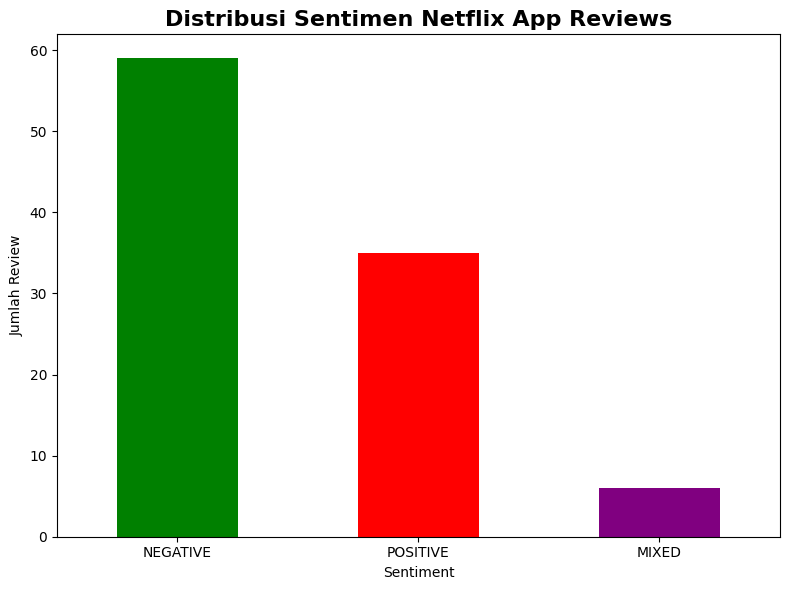

<Figure size 1200x600 with 0 Axes>

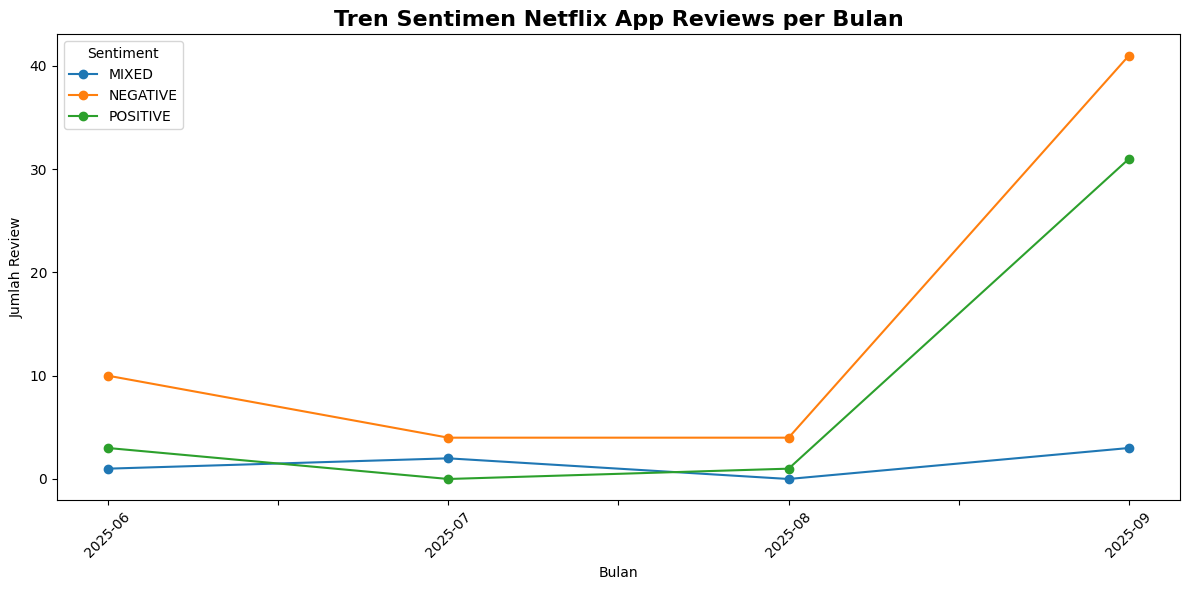

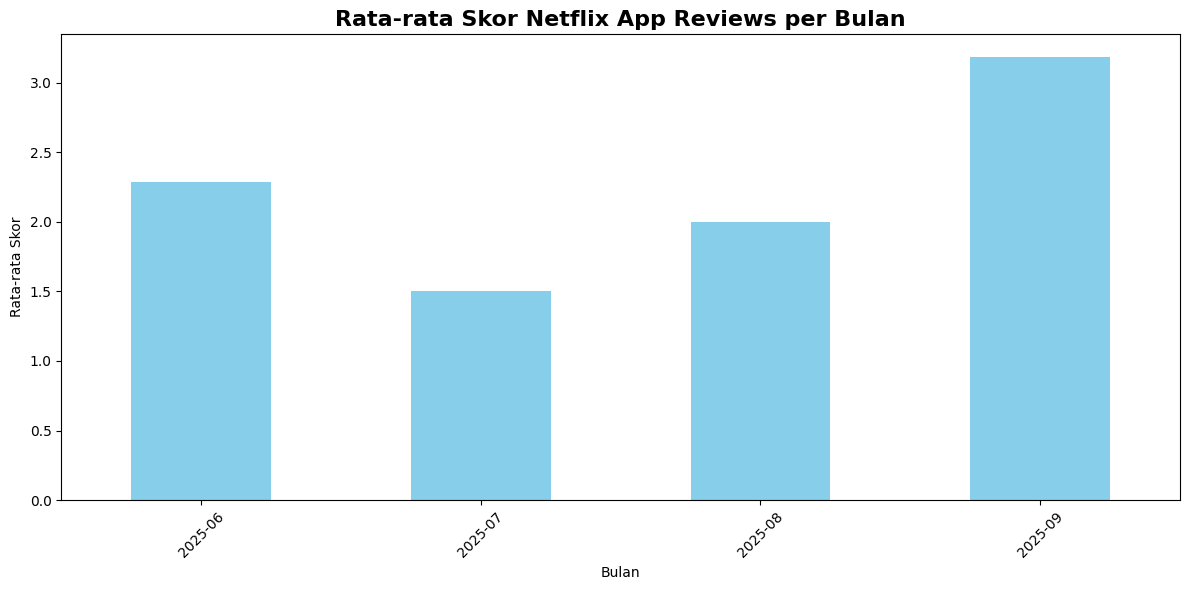

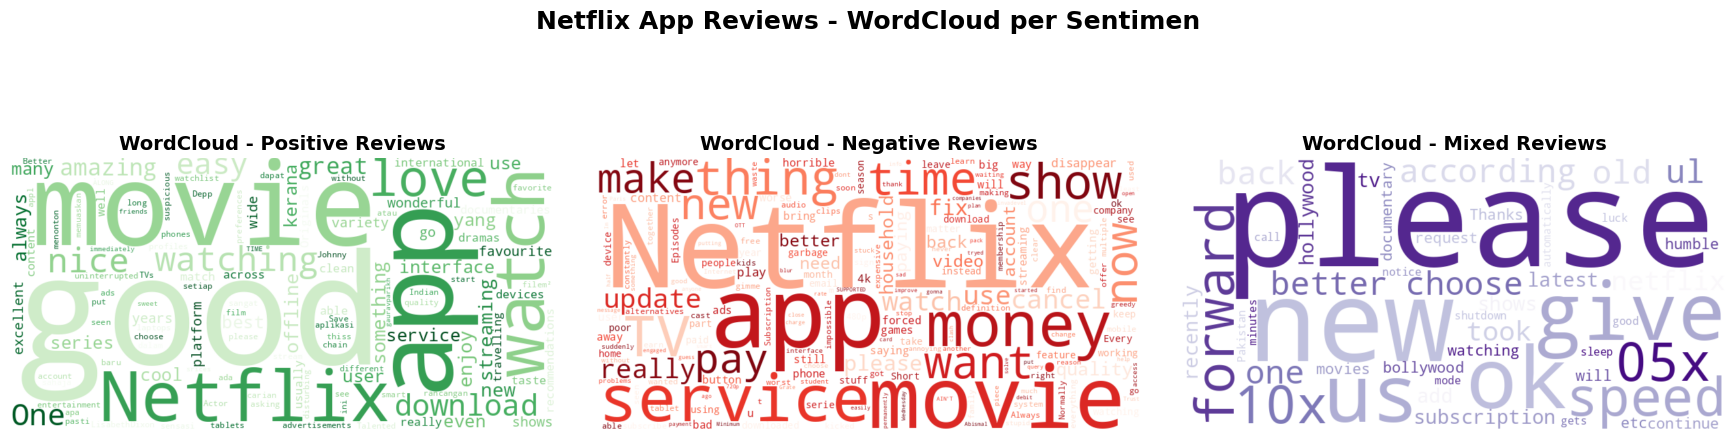

In [11]:
# Pastikan kolom konsisten
df_classify["sentiment"] = df_classify["predicted_label"].str.upper().str.strip()
df_classify["at"] = pd.to_datetime(df_classify["at"])
df_classify["month"] = df_classify["at"].dt.to_period("M").astype(str)

# === 1. Bar Chart Distribusi Sentimen ===
plt.figure(figsize=(8, 6))
sentiment_counts = df_classify["sentiment"].value_counts()
sentiment_counts.plot(kind="bar", color=["green", "red", "purple"])
plt.title("Distribusi Sentimen Netflix App Reviews", fontsize=16, fontweight="bold")
plt.xlabel("Sentiment")
plt.ylabel("Jumlah Review")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# === 2. Tren Sentimen Tiap Bulan ===
plt.figure(figsize=(12, 6))
monthly_sentiment = df_classify.groupby(["month", "sentiment"]).size().unstack(fill_value=0)
monthly_sentiment.plot(kind="line", marker="o", figsize=(12, 6))
plt.title("Tren Sentimen Netflix App Reviews per Bulan", fontsize=16, fontweight="bold")
plt.xlabel("Bulan")
plt.ylabel("Jumlah Review")
plt.xticks(rotation=45)
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()

# === 3. Bar Chart Rata-rata Skor Tiap Bulan ===
plt.figure(figsize=(12, 6))
monthly_scores = df_classify.groupby("month")["score"].mean()
monthly_scores.plot(kind="bar", color="skyblue")
plt.title("Rata-rata Skor Netflix App Reviews per Bulan", fontsize=16, fontweight="bold")
plt.xlabel("Bulan")
plt.ylabel("Rata-rata Skor")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === 4. WordCloud per Sentimen ===
positive_reviews = " ".join(df_classify[df_classify["sentiment"] == "POSITIVE"]["content"].astype(str))
negative_reviews = " ".join(df_classify[df_classify["sentiment"] == "NEGATIVE"]["content"].astype(str))
mixed_reviews    = " ".join(df_classify[df_classify["sentiment"] == "MIXED"]["content"].astype(str))

stopwords = set(STOPWORDS)

def make_wordcloud(text, title, colormap):
    if not text.strip():
        print(f"⚠️ Tidak ada data untuk {title}, dilewati...")
        return None
    wc = WordCloud(
        width=800, height=400,
        background_color="white",
        stopwords=stopwords,
        colormap=colormap
    ).generate(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.title(title, fontsize=14, fontweight="bold")
    plt.axis("off")

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
make_wordcloud(positive_reviews, "WordCloud - Positive Reviews", "Greens")

plt.subplot(1, 3, 2)
make_wordcloud(negative_reviews, "WordCloud - Negative Reviews", "Reds")

plt.subplot(1, 3, 3)
make_wordcloud(mixed_reviews, "WordCloud - Mixed Reviews", "Purples")

plt.suptitle("Netflix App Reviews - WordCloud per Sentimen", fontsize=18, fontweight="bold", y=0.92)
plt.tight_layout(pad=3.0)
plt.show()
